<a href="https://colab.research.google.com/github/xxrjun/ncu-ml-2022-spring/blob/master/HW1_ARTCNN_109403019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個CNN模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個colab的程式來完成訓練CNN模型。**只要跑得出來Testing Accuracy、Loss; 1~7個作業項目即可**，不必一定要照著todo提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的label不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**來引入ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名學號**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的Test Acc
4. 上述兩個檔案繳交至ee-class。

> **繳交期限**

1. 電子商務技術(IM5002): 期限至2022/5/2(一) 23:59分
2. 人工智慧與機器學習(IM3078): 期限至2022/5/2(一) 23:59分
3. 電子商務智慧技術(IMA0200): 期限至2022/4/23(六) 23:59分

> **算分標準**

20 + Test_Acc + Predict function(10分) + 20分文件
1. 20分免費送
2. Test_Acc
3. preditAuthor有寫出來就10分(第七段)
4. 20分是文件分數

有問題再來信助教: ncuzhonghuan@g.ncu.edu.tw

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊colab左側**檔案**來查看

In [ ]:
# import random
# import os 

# # 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# # 以節省學術網路資源，避免IP被封鎖

# if(os.path.isfile("./train.zip") == False):
#   !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
#   !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
#   !echo "分流1"
#   !unzip train.zip
#   !unzip test.zip 
# else:
#   !echo "檔案已存在"

import random
import os 

#把檔案掛載在學校的Gsuite帳號底下
!gdown --id '13rZ48ICcS25IHc3uwJG186ubW5uRNV6V' --output train.zip
!gdown --id '1P3f_r8wP-n5lix8sB2HSz1T9T2qYX3dz' --output test.zip

!unzip train.zip
!unzip test.zip

## 1. 讀入封包

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

## 2. 取得資料集

- **我們來檢視一下artist.csv**，重要內容包含:
  - 畫家名稱(name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有50位畫家，意味者有50個class要去辨識。

In [ ]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ",num_classes)
artists.head()

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


* 只取出名字與畫的數量，把名字用下底線連起來

In [ ]:
artists = artists.loc[:,["name","paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

,name,paintings
0,Amedeo_Modigliani,193
1,Vasiliy_Kandinskiy,88
2,Diego_Rivera,70
3,Claude_Monet,73
4,Rene_Magritte,194


* **計算各個畫家畫作數量**
* 每個class資料的不平衡容易引響模型的訓練，學生可以嘗試解決這個問題。(提示: keras的class_weight)

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


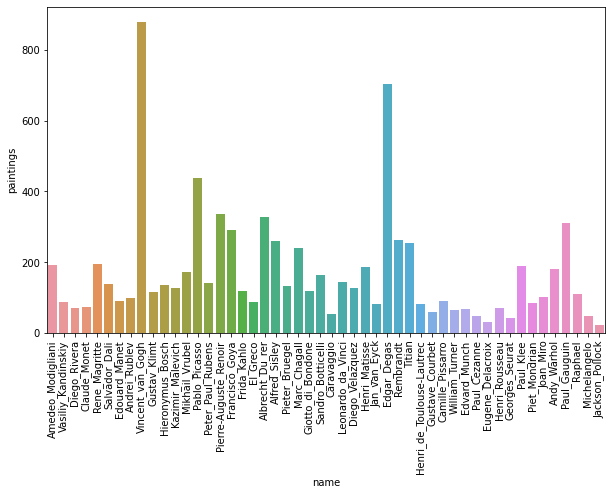

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(artists.name,artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)
    
print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ",artists.paintings.max()," 最少畫作為 : ",artists.paintings.min())

* 計算 class_weight

In [ ]:
artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)

class_weight = artists['class_weight'].to_dict()

artists.head()

,name,paintings,class_weight
0,Amedeo_Modigliani,193,0.875233
1,Vasiliy_Kandinskiy,88,1.919545
2,Diego_Rivera,70,2.413143
3,Claude_Monet,73,2.313973
4,Rene_Magritte,194,0.870722


* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


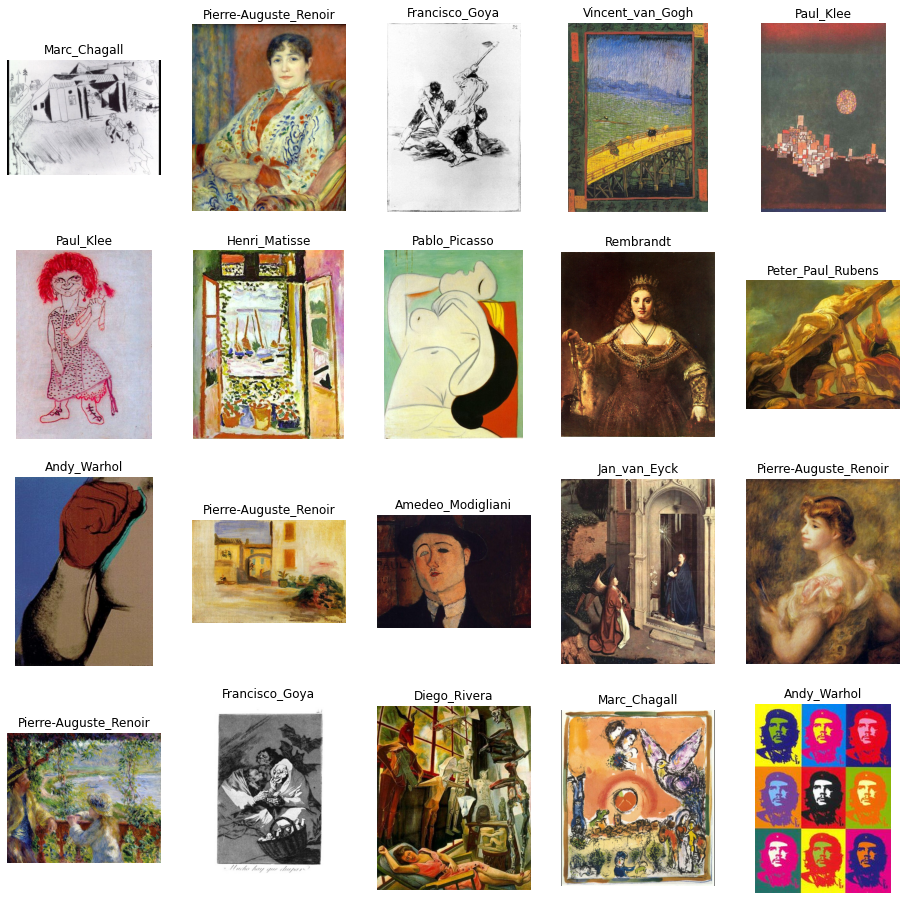

In [ ]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
randomlist = random.sample(range(0,total_len), 20)
print("training 畫作總共畫作有 : ",total_len)

show_imgs = [img_list[rand] for rand in randomlist]

plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出label : Claude_Monet
2. label(作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label數字還要轉乘 50 depth的one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到[0,1]之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料input output的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入tensor後用map將路徑轉成圖片檔案。

* **以下程式todo只是提供程式思路，你完全可以不理他，反正test結果能出來就好。**



In [ ]:
# 請建立將英文映射成數字的dict。EX: Van_Gogh --> 0

author_Dict = dict() # Initial a dictionary

def make_Authordict():
  index = 0

  for i in artists['name']:
    author_Dict[i] = index
    index = index + 1

  return author_Dict

class_name = make_Authordict()

# 請建立將數字映射成英文的dict。 EX: 0 --> Van_Gogh
# k for key, v for value
rev_class_name = {v: k for k, v in class_name.items()}

In [ ]:
def get_label(picName):
  # 請取出label並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  
  # Assign a string to cut
  cut_str  = "_"

  # Get string before the last occurrence of a specified string
  picName = picName.rpartition(cut_str)[0]

  # Return the mapping number
  return author_Dict[picName]

def get_path(dir,picName):
  # 請將路徑合併
  # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
  
  path = dir + picName

  return path

def make_paths_label(dir):
  img_list = os.listdir(dir)
  labels = []
  paths = []

  # 將preprocess完成的path、label用for迴圈放入paths和labels
  for img_name in img_list:
    labels.append(get_label(img_name))
    paths.append(get_path(dir, img_name))
  
  # 將labels轉成onehot
  onehot_labels = keras.utils.to_categorical(labels)
  return paths,onehot_labels

In [ ]:
# 來查看一下
paths,onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
  print(p)
print("-"*20)
print("labels : ")
for label in onehot_labels[:5]:
  print(label)

paths : 
./train_resized/Paul_Gauguin_139.jpg
./train_resized/Francisco_Goya_135.jpg
./train_resized/Pierre-Auguste_Renoir_202.jpg
./train_resized/Paul_Klee_147.jpg
./train_resized/Marc_Chagall_9.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [ ]:
# 轉成tensorflow dataset格式，變成路徑tensor
# 這個只是from_tensor_slices範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
  print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Paul_Gauguin_139.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Francisco_Goya_135.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Pierre-Auguste_Renoir_202.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Paul_Klee_147.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Marc_Chagall_9.jpg', shape=(), dtype=string)


In [ ]:
# 決定你輸入模型的圖片長寬
# shuffle buffer size
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
shuffle_buffer = 1500

def get_image(path):
  # read image from path
  file = tf.io.read_file(path)
  img = tf.io.decode_jpeg(file,channels=3)

  # 請固定每張圖片大小為IMG_HEIGHT、IMG_WIDTH
  # 並將圖片每個pixel映射到[0,1]之間
  img = tf.cast(img,tf.float32)/255
  img = tf.image.resize(img, IMG_SIZE)
  return img

# 將所有資料轉成Tensor -> Tensor 轉成圖片
# 圖片Tensor 與 label Tensor Zip起來成一個pair
# shuffle打散
def make_dataset(dir):
  paths,onehot_labels = make_paths_label(dir)
  paths_ds = tf.data.Dataset.from_tensor_slices(paths)
  train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

  # 將路徑tensor映射成圖片tensor 
  train_image = paths_ds.map(get_image)
  # 合併圖片與label資料集
  full_ds = tf.data.Dataset.zip((train_image,train_label))
  # 打散
  full_ds = full_ds.shuffle(shuffle_buffer,reshuffle_each_iteration=False)
  return full_ds

full_ds = make_dataset(train_dir)

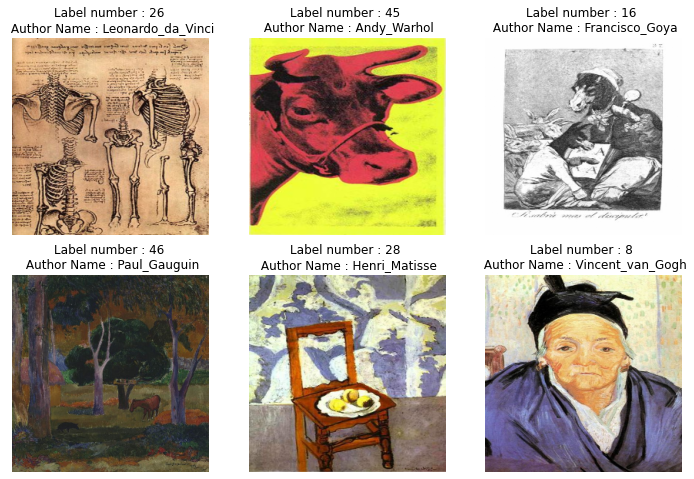

In [ ]:
# 取出Tensor圖片來看看
plt.figure(figsize=(12, 8))
for index,(img,label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(
        l,
        rev_class_name[l]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [ ]:
# 切割成training data與validation data
train_len = int(0.8*total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ",train_len," val size : ",val_len)

# 添加batch. By default 32, should also try 64, 128, 256 or higher.
# The batch size is a hyperparameter that defines the number of samples to 
# work through before updating the internal model parameters.
batch_size = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train size :  6016  val size :  1504


In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (32, 256, 256, 3)
training label batch shape :  (32, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做fine-tuning，**請自己手動建**。

* Dropout: 層跟層之間會 drop 掉一定比例的 neuron (通常為 0.25 ~ 0.5 )，避免 overfitting 的狀況。

In [ ]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

model = keras.Sequential(
    [
      keras.Input(shape=input_shape),
     
      layers.Conv2D(filters=64, kernel_size=(3, 3), activation= "relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.BatchNormalization(),
     
      layers.Conv2D(filters=128, kernel_size=(3, 3), activation= "relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.BatchNormalization(),

      layers.Conv2D(filters=256, kernel_size=(3, 3), activation= "relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.BatchNormalization(),
     
      layers.Conv2D(filters=512, kernel_size=(3, 3), activation= "relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.BatchNormalization(),
     
      layers.GlobalAveragePooling2D(),
      layers.Dropout(0.3),
      layers.Dense(512,activation="relu"),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='softmax')
    ]
)

model.call = tf.function(model.call)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                        

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [ ]:
epochs = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# model.compile 決定learning strategy、Loss caculator
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Create a callbacl that saves the model's weights
cp_callback=keras.callbacks.ModelCheckpoint("art_best/model_{epoch:02d}",save_best_only=True,verbose=1)


history = model.fit(train_ds,epochs=epochs,class_weight=dict(enumerate(class_weight)),validation_data=val_ds,callbacks=[cp_callback])

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 76.0559 - accuracy: 0.1529
Epoch 1: val_loss improved from inf to 4.38719, saving model to art_best/model_01
INFO:tensorflow:Assets written to: art_best/model_01/assets
188/188 [==============================] - 81s 332ms/step - loss: 76.0559 - accuracy: 0.1529 - val_loss: 4.3872 - val_accuracy: 0.0977
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 64.3403 - accuracy: 0.2216
Epoch 2: val_loss did not improve from 4.38719
188/188 [==============================] - 65s 314ms/step - loss: 64.3403 - accuracy: 0.2216 - val_loss: 5.1647 - val_accuracy: 0.0984
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 59.6064 - accuracy: 0.2540
Epoch 3: val_loss improved from 4.38719 to 3.64271, saving model to art_best/model_03
INFO:tensorflow:Assets written to: art_best/model_03/assets
188/188 [==============================] - 65s 322ms/step - loss: 59.6064 - accuracy: 0.2540 - val_lo

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


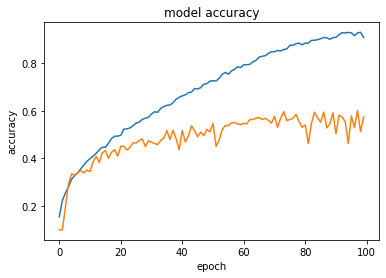

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

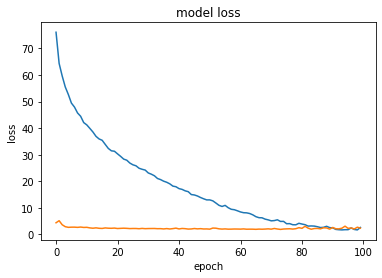

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

27/27 [==============================] - 5s 65ms/step - loss: 2.5554 - accuracy: 0.5257
Test loss: 2.5554158687591553
Test accuracy: 0.5257484912872314


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入Model做預測

In [ ]:
def predictAuthor(img):
  # 寫個單圖片模型預測function
  # input : opencv img (height,width,3)
  # output : 某個作家名字 E.g. Claude_Monet
  #
  # 參考步驟:
  # 1. expand img dimension (height,width,3) -> (1,height,width,3)
  # 2. 丟入模型 model.predict
  # 3. 取出softmax後(50,) 取最大值的index作為辨識結果
  # 4. 將辨識結果轉為畫作家名字

  img = np.expand_dims(img, axis=0)
  authorNo = np.argmax(model.predict([img], steps=1), axis=-1)[0]
  authorName = rev_class_name[authorNo]

  return authorName

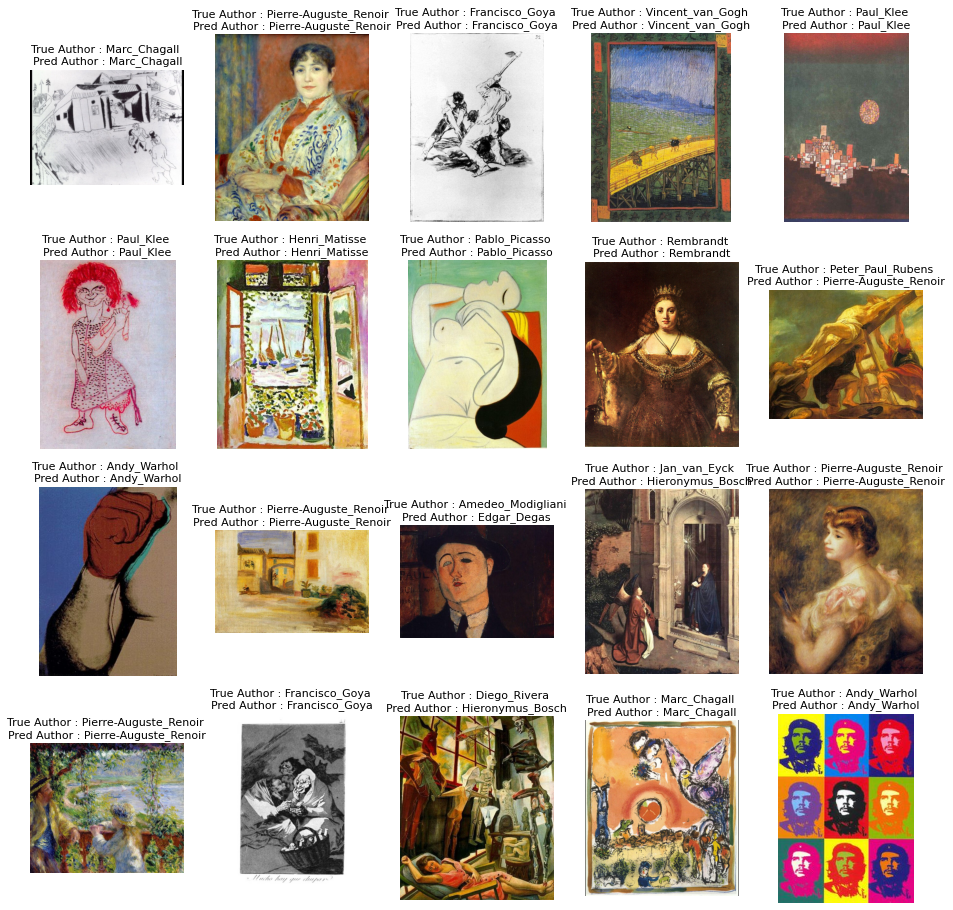

In [ ]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
  imgpath = train_dir+imgName
  img = cv.imread(imgpath)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.subplot(4,5,index+1)
  plt.axis("off")
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img / 255.0
  plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]),predictAuthor(img)),size=11)

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [ ]:
from google.colab import files

def upload_img():
  uploaded = files.upload()
  img_name = list(uploaded.keys())[0]
  img = cv.imread(img_name)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img/255.0
  return img

def eval():
  img = upload_img()
  plt.title("predict author : {}".format(predictAuthor(img)))
  plt.axis("off")
  plt.show()

Saving 959309.jpg to 959309.jpg


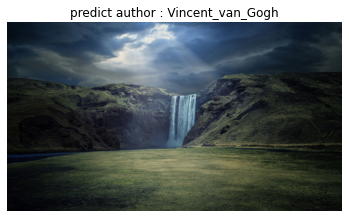

In [ ]:
# 自己上傳一張圖片來試試看
# Demo圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()